<div dir=ltr align=center>In the name of God</div>
<br>
<font size=6><div dir=ltr align=center>
<font size=5>
Intelligent Analysis of
Biomedical Images
<br>
<font size=4>
sharif university of technology, CE department
</font>
<br>
<font size=3>
Dr. Rohban

Designer: Reza Vahidimajd
</font>
<br>
<br>
<font size=6>
Homework 5
</font><br>
<font size=4>


Alireza Sabounchi 401212454

#Vision Transformer for Brain Tumor Image Classification

In this notebook, we delve into the robust capabilities of Vision Transformers (ViT) for tackling the intricate task of image classification using the Brain Tumor dataset. While traditional Convolutional Neural Networks (CNNs) have long been the standard architecture for image-related tasks, ViT introduces a novel approach by leveraging self-attention mechanisms inspired by the Transformer architecture originally developed for natural language processing.

The Brain Tumor dataset utilized here comprises a collection of brain MRI scans, each meticulously categorized into four distinct classes. Our objective is to design and train a custom ViT model that can accurately classify these MRI scans based on their visual features, demonstrating the effectiveness of Vision Transformers in medical image analysis.

#Vision Transformer

A Vision Transformer (ViT) is a cutting-edge deep learning architecture that adapts the Transformer model—originally designed for sequential data like text—to process image data effectively. This innovative approach begins by dividing an input image into fixed-size patches, which are then linearly embedded into vector representations. These embedded vectors are treated as a sequence and fed into Transformer layers, enabling the ViT to capture both local and global dependencies within the image. By leveraging self-attention mechanisms, Vision Transformers can model complex relationships and patterns, making them highly effective for various image analysis tasks.

#Brain Tumor Dataset

The Brain Tumor dataset is a crucial collection of brain MRI scans acquired from patients with and without brain tumors. Each image in the dataset presents a unique challenge due to varying sizes, resolutions, and contrasts. Our goal is to leverage the ViT architecture to develop a robust classification model that can accurately identify the presence of brain tumors in these MRI scans.

# 1. Libabries and Files

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F

In [2]:
!gdown 1nSwAxOS2bCn9m7cXnA-z9-0ADhb4CBuv
!unzip Brain_tumor.zip

Downloading...
From (original): https://drive.google.com/uc?id=1nSwAxOS2bCn9m7cXnA-z9-0ADhb4CBuv
From (redirected): https://drive.google.com/uc?id=1nSwAxOS2bCn9m7cXnA-z9-0ADhb4CBuv&confirm=t&uuid=4d34122f-93ee-4bc1-ac2b-71a6271042d1
To: /kaggle/working/Brain_tumor.zip
100%|████████████████████████████████████████| 156M/156M [00:02<00:00, 53.6MB/s]
Archive:  Brain_tumor.zip
  inflating: Testing/glioma/Te-glTr_0000.jpg  
  inflating: Testing/glioma/Te-glTr_0001.jpg  
  inflating: Testing/glioma/Te-glTr_0002.jpg  
  inflating: Testing/glioma/Te-glTr_0003.jpg  
  inflating: Testing/glioma/Te-glTr_0004.jpg  
  inflating: Testing/glioma/Te-glTr_0005.jpg  
  inflating: Testing/glioma/Te-glTr_0006.jpg  
  inflating: Testing/glioma/Te-glTr_0007.jpg  
  inflating: Testing/glioma/Te-glTr_0008.jpg  
  inflating: Testing/glioma/Te-glTr_0009.jpg  
  inflating: Testing/glioma/Te-gl_0010.jpg  
  inflating: Testing/glioma/Te-gl_0011.jpg  
  inflating: Testing/glioma/Te-gl_0012.jpg  
  inflating: Testin

# 2. Hyperparameters

In [3]:
# Hyperparameters and constants
learning_rate = 0.0001
weight_decay = 0.0001
num_classes = 4
batch_size = 32
num_epochs = 100
class_name = ['glioma', 'meningioma', 'notumor', 'pituitary']

image_size = 256
patch_size = 16
in_channels = 1    # number of channels in input images
embed_dim = 64     # projection dimension (d)
num_heads = 4
num_layers = 12    # e.g., 12 for ViT-B/16 in the original paper
mlp_ratio = 4      # ratio in the MLP (4 is typical in ViT)
dropout_rate = 0.0 # dropout rate
attn_dropout_rate = 0.0

# The number of patches
num_patches = (image_size // patch_size) * (image_size // patch_size)

train_data_path = '/kaggle/working/Training'
test_data_path = '/kaggle/working/Testing'


# 3. Dataset

In [4]:
# Transforms
train_transforms = transforms.Compose([
    ##############################################
    #################### TODO ####################
    ##############################################
    transforms.Grayscale(num_output_channels=1),  # convert to in_channels=1 https://pytorch.org/vision/main/auto_examples/
    transforms.Resize((image_size, image_size)),  # resize images to match input size https://pytorch.org/vision/main/auto_examples/
    # transforms.RandomVerticalFlip(p=0.5),           # random horizontal flip https://pytorch.org/vision/main/auto_examples/
    # transforms.RandomRotation(degrees=(-5, 5)),              # random rotation https://pytorch.org/vision/main/auto_examples/
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5, std=0.5) # normalize for mri
    
])

val_test_transforms = transforms.Compose([
    ##############################################
    #################### TODO ####################
    ##############################################
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5, std=0.5) 

    
])


In [5]:
# Load datasets
full_train_dataset = datasets.ImageFolder(train_data_path, transform=train_transforms)
val_len = int(0.2 * len(full_train_dataset))
train_len = len(full_train_dataset) - val_len
train_dataset, val_dataset = random_split(full_train_dataset, [train_len, val_len])

test_dataset = datasets.ImageFolder(test_data_path, transform=val_test_transforms)

# Create loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


# 4. Model

In [6]:
class PatchEmbedding(nn.Module):
    """
    Splits an image into patches and embeds them into a vector space.
    """
    def __init__(self, img_size=256, patch_size=16, in_chans=1, embed_dim=768):
        """
        Initializes the PatchEmbedding module.

        Args:
            img_size (int): The size of the input image (assumed square).
            patch_size (int): The size of each square patch.
            in_chans (int): Number of input channels in the image.
            embed_dim (int): Dimension of the embedding space.

        TODO:
            - Assert that img_size is divisible by patch_size.
            - Calculate the number of patches.
            - Initialize the projection layer (e.g., nn.Conv2d) to embed patches.
        """
        super(PatchEmbedding, self).__init__()
        # TODO: Implement the initialization logic
        assert img_size % patch_size == 0, "Image size must be divisible by patch size"
        # calculate the number of patches
        self.num_patches = (img_size // patch_size)*(img_size // patch_size)
        
        # projection layer
        self.proj = nn.Conv2d(in_channels=in_chans,
            out_channels=embed_dim,
            kernel_size=patch_size,
            stride=patch_size)
        
    def forward(self, x):
        """
        Forward pass of the PatchEmbedding module.

        Args:
            x (Tensor): Input tensor of shape (batch_size, in_chans, img_size, img_size).

        Returns:
            Tensor: Embedded patches of shape (batch_size, num_patches, embed_dim).

        TODO:
            - Apply the projection layer to the input.
            - Flatten the spatial dimensions to obtain patches.
            - Transpose the tensor to match the desired output shape.
        """
        # TODO: Implement the forward pass
        # apply the projection layer to the input
        x = self.proj(x)  # Shape: (batch_size, embed_dim, num_patches_h, num_patches_w)
        
        # flatten spatial dims
        x = x.flatten(2)  # (batch_size, embed_dim, num_patches)
        x = x.transpose(1, 2)  #(batch_size, num_patches, embed_dim)
        
        return x

with torch.no_grad():
  patch_embedding=PatchEmbedding().cpu().eval()
  patch_embedding_shape=patch_embedding(torch.randn(1,1,256,256)).shape
  print(patch_embedding,patch_embedding_shape)

PatchEmbedding(
  (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(16, 16))
) torch.Size([1, 256, 768])


In [7]:
class TransformerEncoderLayer(nn.Module):
    """
    Single Transformer Encoder Layer consisting of multi-head self-attention and MLP.
    """
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0, dropout_rate=0.1, attn_dropout_rate=0.1):
        """
        Initializes the TransformerEncoderLayer.

        Args:
            embed_dim (int): Dimension of the embedding space.
            num_heads (int): Number of attention heads.
            mlp_ratio (float): Ratio of the hidden dimension in the MLP relative to embed_dim.
            dropout_rate (float): Dropout rate after MLP.
            attn_dropout_rate (float): Dropout rate in the attention layer.

        TODO:
            - Initialize layer normalization layers.
            - Initialize multi-head attention layer.
            - Initialize dropout layers.
            - Initialize MLP (feed-forward) layers.
        """
        super(TransformerEncoderLayer, self).__init__()
        # TODO: Implement the initialization logic
        # Layer norm
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

        # Multi head self attention
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=attn_dropout_rate, batch_first=True)
        
        # Dropout 
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)

        # feed-forward
        hidden_dim = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout_rate))

    def forward(self, x, return_attn=False):
        """
        Forward pass of the TransformerEncoderLayer.

        Args:
            x (Tensor): Input tensor of shape (batch_size, num_tokens, embed_dim).
            return_attn (bool): Whether to return attention weights.

        Returns:
            Tuple[Tensor, Optional[Tensor]]:
                - Output tensor of shape (batch_size, num_tokens, embed_dim).
                - Attention weights if return_attn is True, else None.

        TODO:
            - Apply layer normalization to the input.
            - Perform multi-head self-attention.
            - Add residual connection and apply dropout.
            - Apply second layer normalization.
            - Pass through the MLP.
            - Add residual connection and apply dropout.
            - Return attention weights if requested.
        """
        # TODO: Implement the forward pass
        # layer norm
        x_norm = self.norm1(x)

        #multi-head self attention
        attn_output, attn_weights = self.attn(x_norm, x_norm, x_norm)
        

        # dropout
        x = x + self.dropout1(attn_output)

        # layer norm
        x_norm = self.norm2(x)

        # MLP
        mlp_output = self.mlp(x_norm)

        # dropout
        x = x + self.dropout2(mlp_output)

        if return_attn:
            return x, attn_weights
        return x, None
        
with torch.no_grad():
  transformer_encoder_layer = TransformerEncoderLayer(embed_dim, num_heads).cpu().eval()
  transformer_encoder_layer_shape = transformer_encoder_layer(torch.randn(1, num_patches, embed_dim))[0].shape
  print(transformer_encoder_layer, transformer_encoder_layer_shape)

TransformerEncoderLayer(
  (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
  )
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
  (mlp): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): Dropout(p=0.1, inplace=False)
  )
) torch.Size([1, 256, 64])


In [8]:
class TransformerEncoder(nn.Module):
    """
    Stacks multiple Transformer Encoder Layers to form the Transformer Encoder.
    """
    def __init__(self, num_layers, embed_dim, num_heads, mlp_ratio, dropout_rate, attn_dropout_rate):
        """
        Initializes the TransformerEncoder.

        Args:
            num_layers (int): Number of TransformerEncoderLayer instances to stack.
            embed_dim (int): Dimension of the embedding space.
            num_heads (int): Number of attention heads in each layer.
            mlp_ratio (float): Ratio of the hidden dimension in the MLP relative to embed_dim.
            dropout_rate (float): Dropout rate after MLP.
            attn_dropout_rate (float): Dropout rate in the attention layers.

        TODO:
            - Create a ModuleList containing the specified number of TransformerEncoderLayer instances.
            - Initialize the final layer normalization.
        """
        super(TransformerEncoder, self).__init__()
        # TODO: Implement the initialization logic
        # list of TransformerEncoderLayer instances
        self.layers = nn.ModuleList([TransformerEncoderLayer(
                embed_dim=embed_dim,
                num_heads=num_heads,
                mlp_ratio=mlp_ratio,
                dropout_rate=dropout_rate,
                attn_dropout_rate=attn_dropout_rate) for _ in range(num_layers)])

        # initialize the final layer norm
        self.norm = nn.LayerNorm(embed_dim)
        
    def forward(self, x, return_attn=False):
        """
        Forward pass of the TransformerEncoder.

        Args:
            x (Tensor): Input tensor of shape (batch_size, num_tokens, embed_dim).
            return_attn (bool): Whether to return attention weights from all layers.

        Returns:
            Tuple[Tensor, Optional[List[Tensor]]]:
                - Output tensor of shape (batch_size, num_tokens, embed_dim).
                - List of attention weights from each layer if return_attn is True, else None.

        TODO:
            - Iterate through each TransformerEncoderLayer, passing the input tensor.
            - Collect attention weights if return_attn is True.
            - Apply final layer normalization.
            - Return the output and attention weights as required.
        """
        # TODO: Implement the forward pass
        attn_weights = [] if return_attn else None

        # Pass through each layer
        for layer in self.layers:
            x, attn = layer(x, return_attn)
            if return_attn:
                attn_weights.append(attn)

        #final layer norm
        x = self.norm(x)

        return (x, attn_weights) if return_attn else (x, None)

with torch.no_grad():
  transformer_encoder = TransformerEncoder(num_layers, embed_dim, num_heads, mlp_ratio, dropout_rate, attn_dropout_rate).cpu().eval()
  transformer_encoder_shape = transformer_encoder(torch.randn(1, num_patches, embed_dim))[0].shape
  print(transformer_encoder, transformer_encoder_shape)

TransformerEncoder(
  (layers): ModuleList(
    (0-11): 12 x TransformerEncoderLayer(
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
      (dropout1): Dropout(p=0.0, inplace=False)
      (dropout2): Dropout(p=0.0, inplace=False)
      (mlp): Sequential(
        (0): Linear(in_features=64, out_features=256, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=256, out_features=64, bias=True)
        (4): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
) torch.Size([1, 256, 64])


In [9]:
# with torch.no_grad():
#     transformer_encoder = TransformerEncoder(
#         num_layers=12,
#         embed_dim=64,
#         num_heads=4,
#         mlp_ratio=4.0,
#         dropout_rate=0.0,
#         attn_dropout_rate=0.0
#     ).cpu().eval()
#     transformer_encoder_shape = transformer_encoder(torch.randn(1, 256, 64))[0].shape
#     print(transformer_encoder, transformer_encoder_shape)

In [10]:
class VisionTransformer(nn.Module):
    """
    Vision Transformer (ViT) model for image classification.
    """
    def __init__(self, img_size, patch_size, in_chans, num_classes,
                 embed_dim, num_heads, mlp_ratio, num_layers,
                 dropout_rate, attn_dropout_rate):
        """
        Initializes the VisionTransformer.

        Args:
            img_size (int): Size of the input image (assumed square).
            patch_size (int): Size of each square patch.
            in_chans (int): Number of input channels in the image.
            num_classes (int): Number of output classes for classification.
            embed_dim (int): Dimension of the embedding space.
            num_heads (int): Number of attention heads in each Transformer layer.
            mlp_ratio (float): Ratio of the hidden dimension in the MLP relative to embed_dim.
            num_layers (int): Number of TransformerEncoderLayer instances.
            dropout_rate (float): Dropout rate after embeddings and MLP.
            attn_dropout_rate (float): Dropout rate in the attention layers.

        TODO:
            - Initialize PatchEmbedding.
            - Initialize class token and positional embeddings.
            - Initialize dropout for positional embeddings.
            - Initialize TransformerEncoder.
            - Initialize the classification head (LayerNorm and Linear layer).
            - Initialize model weights.
        """
        super(VisionTransformer, self).__init__()
        # TODO: Implement the initialization logic
        # init PatchEmbedding
        self.patch_embed = PatchEmbedding(img_size=img_size,
            patch_size=patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim)
        
        num_patches = self.patch_embed.num_patches

        # initialize class token and positional embeddings
        self.class_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        #print(class_token, embed_dim, num_patches)
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=dropout_rate)

        #init TransformerEncoder
        self.encoder = TransformerEncoder(num_layers=num_layers,
            embed_dim=embed_dim,
            num_heads=num_heads,
            mlp_ratio=mlp_ratio,
            dropout_rate=dropout_rate,
            attn_dropout_rate=attn_dropout_rate)

        # init classification head
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

        # Init weights
        self._init_weights()

    def _init_weights(self):
        """
        Initializes the weights of the model.

        TODO:
            - Initialize positional embeddings and class token with truncated normal distribution.
            - Apply weight initialization to all modules.
        """
        # TODO: Implement weight initialization
        nn.init.trunc_normal_(self.pos_embed) #truncated normal
        nn.init.trunc_normal_(self.class_token)
        self.apply(self._init_module_weights)

    def _init_module_weights(self, module):
        """
        Initializes weights for individual modules.

        Args:
            module (nn.Module): The module to initialize.

        TODO:
            - Initialize Linear layers with truncated normal for weights and zeros for biases.
            - Initialize LayerNorm layers with ones for weights and zeros for biases.
            - Initialize Conv2d layers with Kaiming normal for weights and zeros for biases.
        """
        # TODO: Implement module-specific weight initialization
        if isinstance(module, nn.Linear):
            nn.init.trunc_normal_(module.weight)
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)
        elif isinstance(module, nn.LayerNorm):
            nn.init.constant_(module.bias, 0)
            nn.init.constant_(module.weight, 1)
        elif isinstance(module, nn.Conv2d):
            nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu') #from torch website
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)


    def forward(self, x, return_attn=False):
        """
        Forward pass of the VisionTransformer.

        Args:
            x (Tensor): Input tensor of shape (batch_size, in_chans, img_size, img_size).
            return_attn (bool): Whether to return attention maps from the Transformer.

        Returns:
            Tuple[Tensor, Optional[List[Tensor]]]:
                - Logits tensor of shape (batch_size, num_classes).
                - List of attention maps from each Transformer layer if return_attn is True, else None.

        TODO:
            - Embed the input patches using PatchEmbedding.
            - Concatenate the class token to the patch embeddings.
            - Add positional embeddings to the combined embeddings.
            - Apply dropout to the embeddings.
            - Pass the embeddings through the TransformerEncoder.
            - Extract the class token's representation.
            - Pass the class token through the classification head to obtain logits.
            - Return logits and attention maps as required.
        """
        # TODO: Implement the forward pass
        # embed input patches
        x = self.patch_embed(x)
        #print (x, x.shape)

        # concat class token
        batch_size = x.size(0)
        class_token = self.class_token.expand(batch_size, -1, -1)
        x = torch.cat((class_token, x), dim=1)
        #print(x, class_token)

        # positional embeddings and dropout
        x = x + self.pos_embed
        x = self.pos_drop(x)

        # TransformerEncoder
        x, attn_weights = self.encoder(x, return_attn)
        #print(:the att weights are:, attn_weights)

        # class token representation
        class_token = x[:, 0]

        # classification head
        logits = self.head(self.norm(class_token))

        return (logits, attn_weights) if return_attn else (logits, None)

# with torch.no_grad():
#   vision_transformer = VisionTransformer().cpu().eval()
#   vision_transformer_shape = vision_transformer(torch.randn(1, 1, 256, 256))[0].shape
#   print(vision_transformer, vision_transformer_shape)


In [11]:
# with torch.no_grad():
#     vision_transformer = VisionTransformer(img_size=256,
#         patch_size=16,
#         in_chans=1,
#         num_classes=1000,
#         embed_dim=768,
#         num_heads=12,
#         mlp_ratio=4.0,
#         num_layers=12,
#         dropout_rate=0.1,
#         attn_dropout_rate=0.1).cpu().eval()
#     vision_transformer_shape = vision_transformer(torch.randn(1, 1, 256, 256))[0].shape
#     print(vision_transformer, vision_transformer_shape)

In [12]:
# Setup the device, model, loss, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VisionTransformer(
    img_size=image_size,
    patch_size=patch_size,
    in_chans=in_channels,
    num_classes=num_classes,
    embed_dim=embed_dim,
    num_heads=num_heads,
    mlp_ratio=mlp_ratio,
    num_layers=num_layers,
    dropout_rate=dropout_rate,
    attn_dropout_rate=attn_dropout_rate
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


# 5. Training

In [13]:
# Initialize lists to store metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop
best_val_acc = 0.0
best_model_path = 'best_vit_model.pth'

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    total_train = 0
    # print(len(train_loader))
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        # print(".", end="")
        ##############################################
        #################### TODO ####################
        ##############################################
        # forward pass
        outputs, _ = model(images) #attn_weights is second
        loss = criterion(outputs, labels)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # metrics
        train_loss += loss.item() * images.size(0)  # total loss
        _, preds = torch.max(outputs, dim=1)  # pred class
        train_correct += (preds == labels).sum().item()  # correct preds
        total_train += labels.size(0)  # total samples
        ##############################################
    
    train_acc = train_correct / total_train
    train_loss = train_loss / total_train

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            ##############################################
            #################### TODO ####################
            ##############################################
            # forward 
            outputs, _ = model(images)
            loss = criterion(outputs, labels)

            # metrics
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, dim=1)
            val_correct += (preds == labels).sum().item()
            total_val += labels.size(0)
            ##############################################

    val_acc = val_correct / total_val
    val_loss = val_loss / total_val

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Append metrics to lists
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)


Epoch [1/100], Train Loss: 1.5738, Train Acc: 0.4678, Val Loss: 1.0869, Val Acc: 0.4974
Epoch [2/100], Train Loss: 1.0042, Train Acc: 0.6068, Val Loss: 0.9293, Val Acc: 0.6366
Epoch [3/100], Train Loss: 0.9381, Train Acc: 0.6359, Val Loss: 0.9388, Val Acc: 0.6235
Epoch [4/100], Train Loss: 0.9144, Train Acc: 0.6396, Val Loss: 0.9263, Val Acc: 0.6410
Epoch [5/100], Train Loss: 0.8735, Train Acc: 0.6573, Val Loss: 0.9384, Val Acc: 0.6235
Epoch [6/100], Train Loss: 0.8506, Train Acc: 0.6654, Val Loss: 0.8685, Val Acc: 0.6655
Epoch [7/100], Train Loss: 0.8397, Train Acc: 0.6711, Val Loss: 0.8334, Val Acc: 0.6681
Epoch [8/100], Train Loss: 0.7987, Train Acc: 0.6888, Val Loss: 0.8543, Val Acc: 0.6673
Epoch [9/100], Train Loss: 0.7804, Train Acc: 0.6860, Val Loss: 0.7526, Val Acc: 0.7032
Epoch [10/100], Train Loss: 0.7305, Train Acc: 0.7166, Val Loss: 0.7306, Val Acc: 0.7163
Epoch [11/100], Train Loss: 0.7024, Train Acc: 0.7295, Val Loss: 0.7208, Val Acc: 0.7119
Epoch [12/100], Train Loss: 0.

# 6. Evaluation

In [14]:
# Load best model
model.load_state_dict(torch.load(best_model_path))

# Test evaluation
model.eval()
test_correct = 0
test_total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        ##############################################
        #################### TODO ####################
        ##############################################
        # forward pass
        outputs, _ = model(images) # outs, attn_weights

        # predictions
        _, preds = torch.max(outputs, dim=1)

        # metrics
        test_correct += (preds == labels).sum().item()  # Count correct predictions
        test_total += labels.size(0)  # all samples

        # Save
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        ##############################################
test_acc = test_correct / test_total

print(f"Test Accuracy: {test_acc:.4f}")


<ipython-input-14-c05cde77a58c>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Test Accuracy: 0.8871


# 7. Loss Plots and Confusion Matrix

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

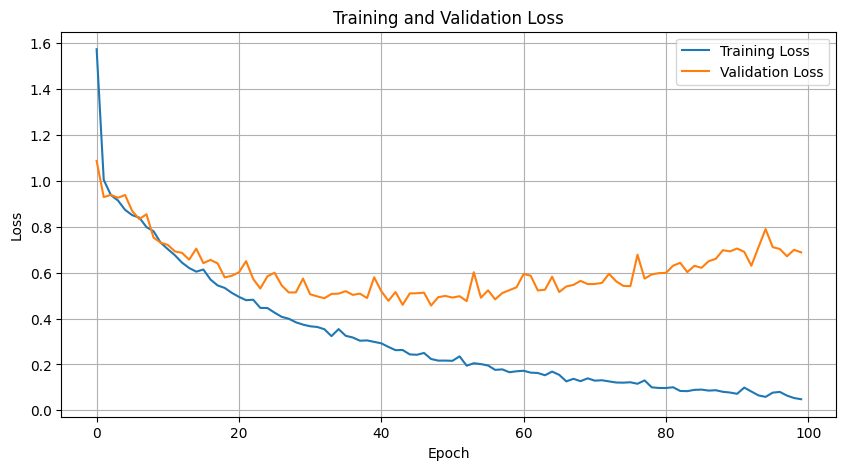

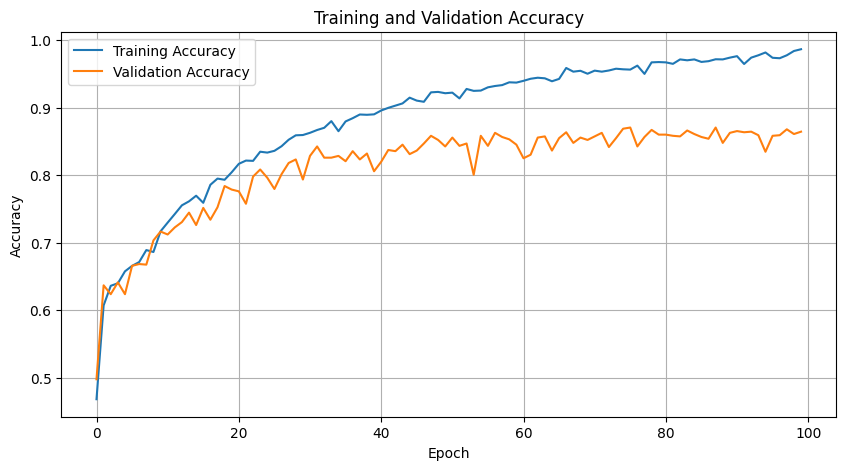

In [16]:
# Plotting Training and Validation Loss

##############################################
#################### TODO ####################
##############################################
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Training and Validation Accuracy

##############################################
#################### TODO ####################
##############################################
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

<Figure size 800x600 with 0 Axes>

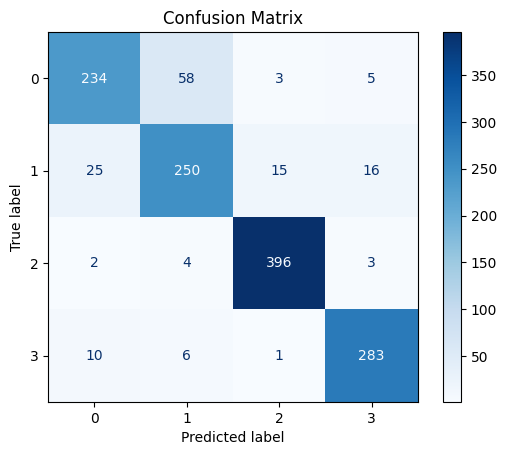

In [17]:
# Collect all predictions and true labels for the test set
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:

        ##############################################
        #################### TODO ####################
        ##############################################
        images, labels = images.to(device), labels.to(device)

        outputs, _ = model(images)
        
        # predictions
        _, preds = torch.max(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix

##############################################
#################### TODO ####################
##############################################
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(num_classes))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

# 8. Visualize Attention of the Model

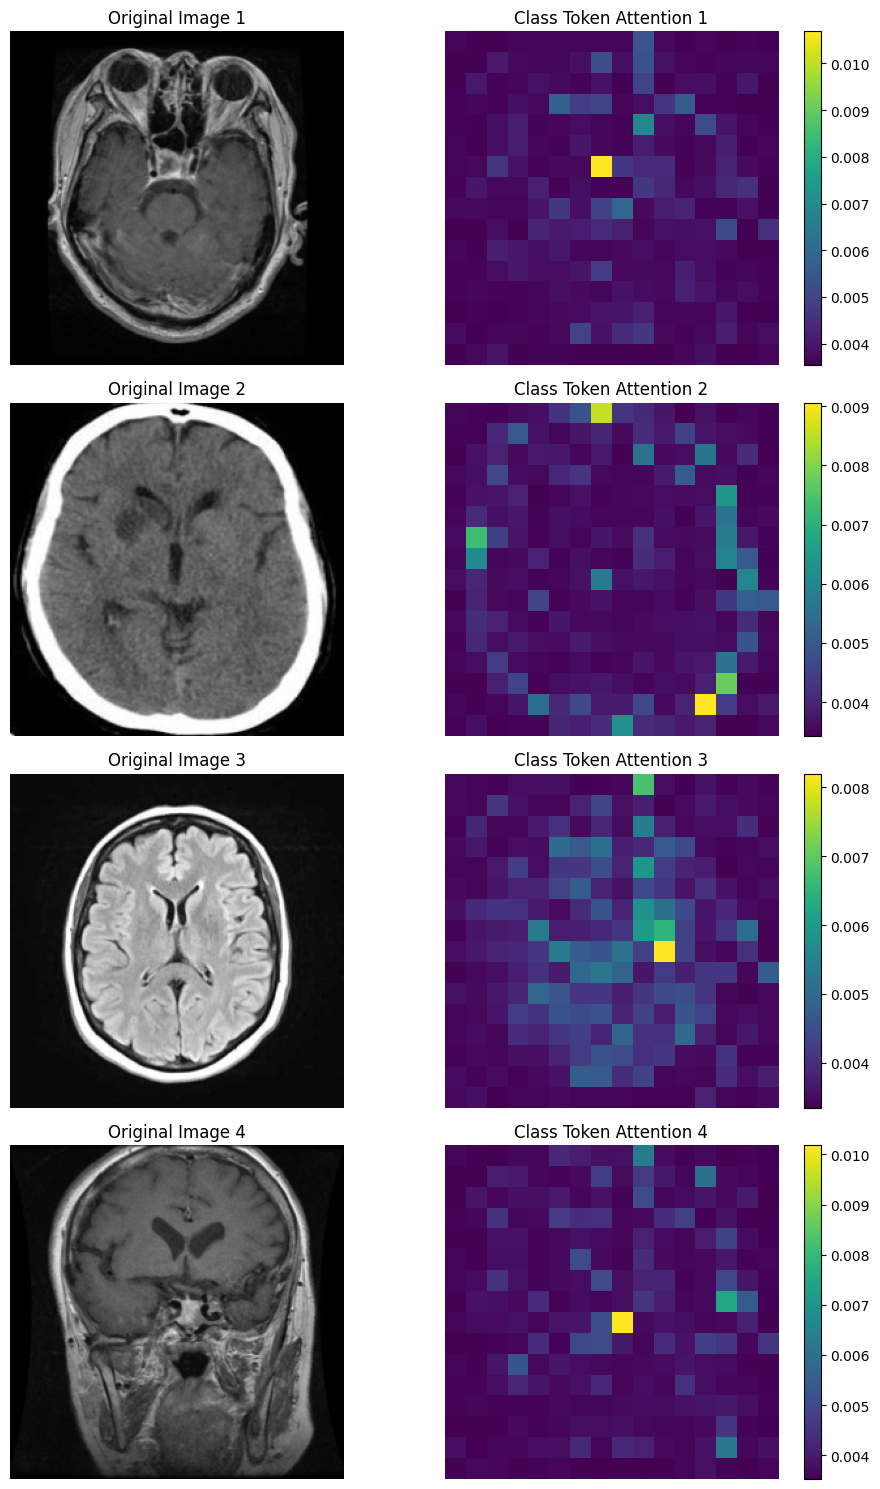

In [18]:
import matplotlib.pyplot as plt
import numpy as np

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        
        logits, attn_maps = model(images, return_attn=True)

        ##################################################
        ####################### TODO #####################
        # Compute the 2d attention map for 4 different   #
        # images showing the attention of the model      #
        # on each patch of the image                     #
        ##################################################
        ##################################################

        # attn_map_2d = ...
        
        #  mean across all 32 layers
        avg_attn_maps = torch.stack(attn_maps).mean(dim=0)
        
        # attention weights for CLS (first token)
        # Shape: [batch_size, num_patches + 1] 257x257
        cls_attn = avg_attn_maps[:, 0, 1:]
        
        # Reshape to 2D
        num_patches = int(np.sqrt(cls_attn.shape[1])) #16
        
        fig, axes = plt.subplots(4, 2, figsize=(10, 15))
        for idx in range(4):
            # reshape to 2D grid for current
            attn_map_2d = cls_attn[idx].reshape(num_patches, num_patches)
            attn_map_2d = attn_map_2d.cpu().numpy()

            img_np = images[idx].cpu().numpy().transpose(1, 2, 0)
            
            # original image
            axes[idx, 0].imshow(img_np, cmap='gray')
            axes[idx, 0].set_title(f'Original Image {idx+1}')
            axes[idx, 0].axis('off')
            
            # attention map
            im = axes[idx, 1].imshow(attn_map_2d, cmap='viridis')
            axes[idx, 1].set_title(f'Class Token Attention {idx+1}')
            axes[idx, 1].axis('off')
            plt.colorbar(im, ax=axes[idx, 1])
        
        plt.tight_layout()
        plt.show()
        break  # Only show first batch